In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os
import sys

print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

oliva-titanrtx-2.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
import gymnasium as gym
import util

import data_utils

data_dir = "~/synthetic-mdps-data/"
data_dir = os.path.expanduser(data_dir)

d_obs_uni, d_act_uni = 128, 16
env_id = "HalfCheetah"
env_id_gym = f"{env_id}-v4"

/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [203]:
dataset = data_utils.load_dataset(f"{data_dir}/datasets/mujoco/{env_id}/dataset.pkl")
dataset_train_ori, dataset_test_ori = data_utils.train_test_split(dataset, percent_train=0.8)
del dataset
transform_params = data_utils.get_dataset_transform_params(jax.random.PRNGKey(0), dataset_train_ori,
                                                           d_obs_uni=d_obs_uni, d_act_uni=d_act_uni)

dataset_train_ori = jax.tree_map(lambda x: jnp.array(x), dataset_train_ori)
dataset_test_ori = jax.tree_map(lambda x: jnp.array(x), dataset_test_ori)
transform_params = jax.tree_map(lambda x: jnp.array(x), transform_params)

dataset_train_uni = data_utils.transform_dataset(dataset_train_ori, transform_params)
dataset_test_uni = data_utils.transform_dataset(dataset_test_ori, transform_params)
print(jax.tree_map(lambda x: (x.shape, x.dtype, type(x)), dataset_train_uni))

{'act': ((51, 16384, 16), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'done': ((51, 16384), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'obs': ((51, 16384, 128), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'rew': ((51, 16384), dtype('float32'), <class 'jaxlib.xla_extension.ArrayImpl'>), 'time': ((51, 16384), dtype('int32'), <class 'jaxlib.xla_extension.ArrayImpl'>)}


In [204]:
def sample_batch(rng, dataset, bs, ctx_len):
    _rng1, _rng2 = split(rng)
    B, T, _ = dataset['obs'].shape
    i_b = jax.random.randint(_rng1, (bs, 1), 0, B)
    i_t = jax.random.randint(_rng2, (bs, 1), 0, T - ctx_len)
    i_t = i_t + jnp.arange(ctx_len)
    return jax.tree_map(lambda x: x[i_b, i_t], dataset)

In [205]:
def make_env(env_id, idx=0, vid_dir=None):
    def thunk():
        if vid_dir is not None and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, vid_dir)
        else:
            env = gym.make(env_id)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        return env

    return thunk

def transform_forward_fn(forward_fn, transform_params):
    """
    Given a forward function in universal space, converts it to a forward function in original space
    """
    def new_forward_fn(obs):
        obs_agent = data_utils.transform_obs(obs, transform_params)
        act_agent = forward_fn(obs_agent)
        act = data_utils.inverse_transform_act(act_agent, transform_params)
        return act
    return new_forward_fn


def get_agent_return(env_id, num_envs, n_steps, forward_fn, vid_dir=None, ret_buffer=False):
    envs = gym.vector.SyncVectorEnv(
        [make_env(f"{env_id}", i, vid_dir) for i in range(num_envs)]
    )
    obs, infos = envs.reset()
    o, a = [], []
    rets, lens = [], []
    for _ in tqdm(range(n_steps), desc="Rollout"):
        act = forward_fn(obs)
        a.append(act)
        o.append(obs)
        obs, rew, term, trunc, infos = envs.step(act)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    rets.append(info["episode"]["r"])
                    lens.append(info["episode"]["l"])
    if ret_buffer:
        return np.array(rets), np.array(lens), np.stack(o, axis=1), np.stack(a, axis=1)
    else:
        return np.array(rets), np.array(lens)


def get_agent_test_loss(rng, bs, n_iters, forward_fn):
    mse_uni, mse_ori = [], []
    for _ in tqdm(range(n_iters)):
        rng, _rng = split(rng)
        batch_ori = sample_batch(_rng, dataset_test_ori, bs, 1)
        batch_ori = jax.tree_map(lambda x: x[:, 0], batch_ori)
        batch_uni = sample_batch(_rng, dataset_test_uni, bs, 1)
        batch_uni = jax.tree_map(lambda x: x[:, 0], batch_uni)
        
        act_uni_pred = forward_fn(batch_uni['obs'])
        act_ori_pred = data_utils.inverse_transform_act(act_uni_pred, transform_params)
        mse_uni_i = np.mean(jnp.square(act_uni_pred - batch_uni['act']), axis=-1)
        mse_ori_i = np.mean(jnp.square(act_ori_pred - batch_ori['act']), axis=-1)
        mse_uni.append(mse_uni_i)
        mse_ori.append(mse_ori_i)
    return np.concatenate(mse_uni), np.concatenate(mse_ori)


In [206]:
rets_zeros, _ = get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(lambda x: np.zeros((x.shape[0], d_act_uni)), transform_params))
rets_randn, _ = get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(lambda x: np.random.normal(size=(x.shape[0], d_act_uni)), transform_params))

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

In [207]:
print("Zero Agent Return: ", rets_zeros.mean())
print("Randn Agent Return: ", rets_randn.mean()) 

Zero Agent Return:  -66.59639
Randn Agent Return:  -167.83264


In [208]:
(dataset_train_uni['act']**2).mean()

Array(1.0092651, dtype=float32)

# MLP BC

In [174]:
class Agent(nn.Module):
    d_obs: int
    d_act: int

    @nn.compact
    def __call__(self, x):
        act = nn.Sequential([
            nn.Dense(64),
            nn.tanh,
            nn.Dense(64),
            nn.tanh,
            nn.Dense(self.d_act, kernel_init=nn.initializers.normal(stddev=0.01)),
        ])(x)
        return act

agent_mlp = Agent(d_obs=d_obs_uni, d_act=d_act_uni)

In [175]:
def train_step(rng, train_state):
    def loss_fn(params, batch):
        act_pred = jax.vmap(agent_mlp.apply, in_axes=(None, 0))(params, batch['obs'])
        loss = jnp.mean(jnp.square(act_pred - batch['act']))
        return loss

    batch = sample_batch(rng, dataset_train_uni, bs, 1)
    batch = jax.tree_map(lambda x: x[:, 0], batch)

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(train_state.params, batch)
    train_state = train_state.apply_gradients(grads=grad)
    return train_state, loss

train_step = jax.jit(train_step)

In [176]:
bs = 32
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
batch = sample_batch(_rng, dataset_train_uni, bs, 1)
batch = jax.tree_map(lambda x: x[:, 0], batch)
agent_params = agent_mlp.init(_rng, batch['obs'][0])
tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent_mlp.apply, params=agent_params, tx=tx)

data = []
for i in tqdm(range(50000 + 1)):
    # if i % 1000 == 0:
    #     def forward_fn(x):
    #         return agent_mlp.apply(train_state.params, x)
    #     rets, _ = get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(forward_fn, transform_params))
    #     test_loss, _ = get_agent_test_loss(_rng, 512, 100, forward_fn)
    #     data.append([rets.mean(), test_loss.mean()])
    rng, _rng = split(rng)
    train_state, loss = train_step(_rng, train_state)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [177]:
params_mlp = train_state.params

In [178]:
loss

Array(0.00594396, dtype=float32)

In [206]:
forward_fn_mlp = forward_fn

In [207]:
[i[0].mean() for i in data]

[0.54308397, 259.8147]

In [208]:
[i[1].mean() for i in data]

[1.0126624, 0.055839747]

In [209]:
data_mlp = data
data_mlp = np.array(data_mlp)

In [212]:
data_mlp[:, 0], data_mlp[:, 1]

(array([  0.54308397, 259.8147    ], dtype=float32),
 array([1.0126624 , 0.05583975], dtype=float32))

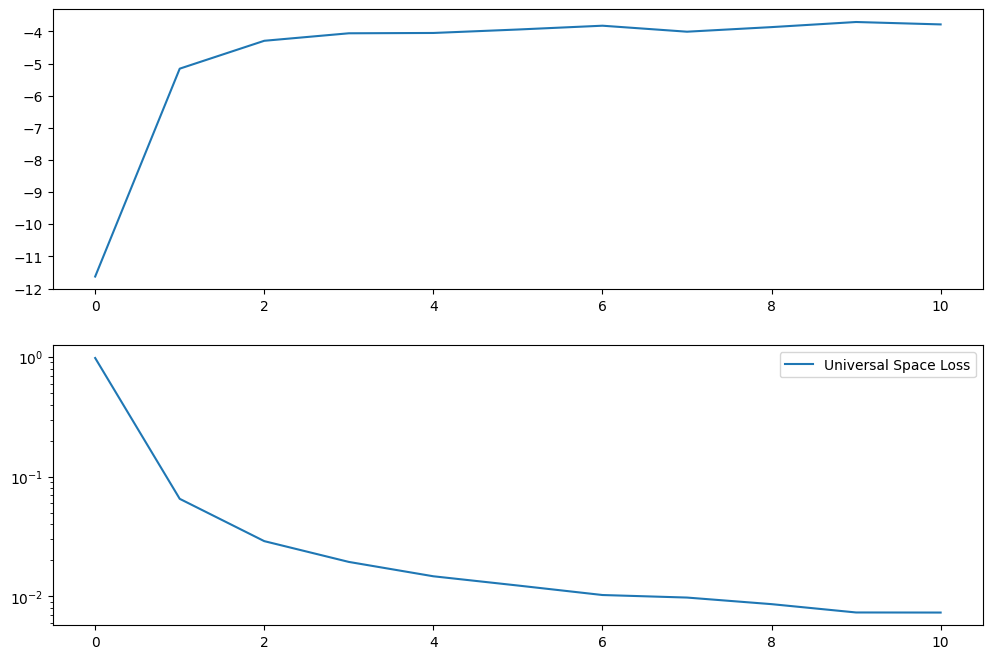

In [291]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(data_mlp[:, 0], label="Rollout Return")
plt.subplot(212)
plt.plot(data_mlp[:, 1], label="Universal Space Loss")
# plt.plot(data_mlp[:, 2], label="Original Space Loss")
plt.yscale('log')
plt.legend()
plt.show()


# Transformer BC

In [218]:
from agents.regular_transformer import Block

In [219]:
class BCTransformer(nn.Module):
    d_obs: int
    d_act: int
    n_layers: int
    n_heads: int
    d_embd: int
    ctx_len: int

    mask_type: str = "causal"

    def setup(self):
        self.embed_obs = nn.Dense(features=self.d_embd)
        self.embed_act = nn.Dense(features=self.d_embd)
        self.embed_pos = nn.Embed(num_embeddings=self.ctx_len, features=self.d_embd)

        self.blocks = [Block(n_heads=self.n_heads, mask_type=self.mask_type) for _ in range(self.n_layers)]
        self.ln = nn.LayerNorm()

        self.actor = nn.Dense(features=self.d_act, kernel_init=nn.initializers.orthogonal(0.01))  # T, Da

    def __call__(self, obs, act):  # obs: (T, Do), # act: (T, Da), # time: (T, )
        assert obs.shape[0] == act.shape[0]
        assert obs.shape[0] <= self.ctx_len
        T, _ = obs.shape

        x_obs = self.embed_obs(obs)  # (T, D)
        x_act = self.embed_act(act)  # (T, D)
        x_pos = self.embed_pos(jnp.arange(T))  # (T, D)
        x_act_p = jnp.concatenate([jnp.zeros((1, self.d_embd)), x_act[:-1]], axis=0)

        x = x_obs + x_act_p + x_pos
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)

        act_now_pred = self.actor(x)
        # obs_nxt_pred = self.wm(x)
        return act_now_pred

    
    # def query_obs(self, obs, act, obs_query):
    #     assert obs.shape[0] == act.shape[0]
    #     assert obs.shape[0] <= self.ctx_len
    #     T, _ = obs.shape

    #     obs = obs.copy()
    #     obs[-1] = obs_query

    #     x_obs = self.embed_obs(obs)  # (T, D)
    #     x_act = self.embed_act(act)  # (T, D)
    #     x_pos = self.embed_pos(jnp.arange(T))  # (T, D)
    #     x_act_p = jnp.concatenate([jnp.zeros((1, self.d_embd)), x_act[:-1]], axis=0)

    #     x = x_obs + x_act_p + x_pos

    #     x_kv = 
    #     for block in self.blocks:
    #         x = block(x)
    #     x = self.ln(x)

    #     act_now_pred = self.actor(x)
    #     # obs_nxt_pred = self.wm(x)
    #     return act_now_pred

        
    
def augment_batch(rng, batch, n_augs, dist="uniform", mat_type='gaussian'):
    if n_augs == 0:
        return batch
    bs, _, d_obs = batch['obs'].shape
    bs, _, d_act = batch['act'].shape

    def augment_instance(instance, aug_id):
        rng = jax.random.PRNGKey(aug_id)
        _rng_obs, _rng_act = split(rng, 2)
        if mat_type == 'gaussian':
            obs_mat = jax.random.normal(_rng_obs, (d_obs, d_obs)) / jnp.sqrt(d_obs)
            act_mat = jax.random.normal(_rng_act, (d_act, d_act)) / jnp.sqrt(d_act)
        elif mat_type == 'orthogonal':
            obs_mat = jax.random.orthogonal(_rng_obs, d_obs)
            act_mat = jax.random.orthogonal(_rng_act, d_act)
        else:
            raise NotImplementedError
        return dict(obs=instance['obs'] @ obs_mat.T, act=instance['act'] @ act_mat.T)

    if dist == "uniform":
        aug_ids = jax.random.randint(rng, (bs,), minval=0, maxval=n_augs)
    elif dist == "zipf":
        p = 1 / jnp.arange(1, n_augs + 1)
        aug_ids = jax.random.choice(rng, jnp.arange(n_augs), (bs,), p=p / p.sum())
    else:
        raise NotImplementedError

    return jax.vmap(augment_instance)(batch, aug_ids)

def augment_batch_permute(rng, batch):
    bs, ctx_len, d_obs = batch['obs'].shape
    def augment_instance(_rng, instance):
        perm = jax.random.permutation(_rng, ctx_len)
        return dict(obs=instance['obs'][perm], act=instance['act'][perm])
    return jax.vmap(augment_instance)(split(rng, bs), batch)
    

In [220]:
bs, ctx_len = 32, 128
agent = BCTransformer(d_obs=d_obs_uni, d_act=d_act_uni, n_layers=2, n_heads=4, d_embd=128*4, ctx_len=ctx_len, mask_type='causal')
jit_vmap_agent_apply = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))

In [221]:
def train_step(rng, train_state):
    def loss_fn(params, batch):
        out = jax.vmap(agent.apply, in_axes=(None, 0, 0))(params, batch['obs'], batch['act'])
        mse = jnp.mean(jnp.square(out - batch['act']), axis=(0, -1)) # mean over batch, dim
        loss = mse.mean() # mean over ctx
        metrics = dict(loss=loss, mse=mse)
        return loss, metrics
    _rng1, _rng2, _rng3 = split(rng, 3)
    batch = sample_batch(_rng1, dataset_train_uni, bs, ctx_len)
    # batch = augment_batch_permute(_rng3, batch)
    
    # batch = sample_batch(_rng1, dataset_train_uni, bs*ctx_len, 1)
    # batch = jax.tree_map(lambda x: x.reshape(bs, ctx_len, -1), batch)
    
    batch = augment_batch(_rng2, batch, n_augs=int(1e8), dist='uniform', mat_type='orthogonal')
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, metrics), grad = grad_fn(train_state.params, batch)
    train_state = train_state.apply_gradients(grads=grad)
    return train_state, metrics
train_step = jax.jit(train_step)

In [222]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
batch = sample_batch(_rng, dataset_train_uni, bs, ctx_len)
agent_params = agent.init(_rng, batch['obs'][0], batch['act'][0])
print(sum([p.size for p in jax.tree_util.tree_leaves(agent_params)]))

tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(1e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

data = []
mse = []
for i in tqdm(range(50000 + 1)):
    # if i % 25000 == 0:
    #     def forward_fn(x):
    #         batch = sample_batch(_rng, dataset_train_uni, len(x), ctx_len)
    #         batch = jax.tree_map(lambda x: x.copy(), batch)
    #         batch['obs'] = batch['obs'].at[:, -1].set(x)
    #         act_pred = jit_vmap_agent_apply(train_state.params, batch['obs'], batch['act'])
    #         return act_pred[:, -1]
    #     rets, lens = get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(forward_fn, transform_params))
    #     test_losses, _ = get_agent_test_loss(_rng, 512, 100, forward_fn)
    #     data.append([rets.mean(), test_losses.mean()])
    rng, _rng = split(rng)
    train_state, metrics = train_step(_rng, train_state)
    mse.append(metrics['mse'])

Using causal mask
Using causal mask
6454288


  0%|          | 0/50001 [00:00<?, ?it/s]

Using causal mask
Using causal mask


In [225]:
params_trans = train_state.params

In [226]:
forward_fn_trans = forward_fn

In [227]:
mse = np.array(mse)

In [228]:
data_trans = data
data_trans = np.array(data_trans)
data_trans

array([], dtype=float64)

In [229]:
data_trans[:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
data_trans[:, 0]

In [ ]:
data_trans

In [ ]:
mse.shape

In [227]:
data_trans[:, 0]

array([ 0.11032702, 21.25026   , 23.412357  ], dtype=float32)

(0.01, 1.0)

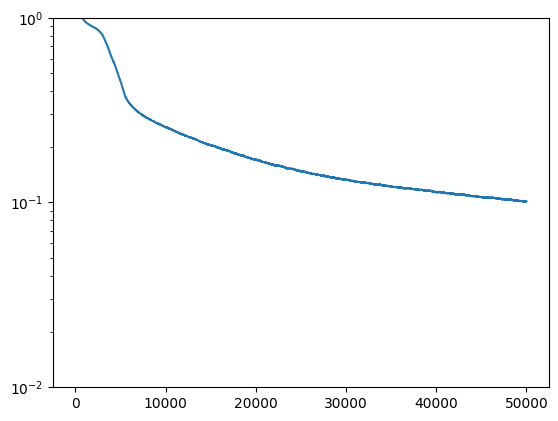

In [241]:
pd.Series(mse.mean(axis=-1)).ewm(span=400).mean().plot()
plt.yscale('log')
plt.ylim(1e-2, 1e0)

<Axes: >

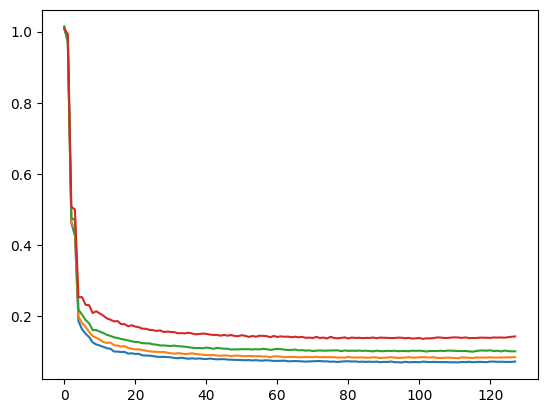

In [230]:
pd.DataFrame(mse).ewm(span=400).mean().iloc[-1].plot()
pd.DataFrame(mse).ewm(span=400).mean().iloc[-10000].plot()
pd.DataFrame(mse).ewm(span=400).mean().iloc[-20000].plot()
pd.DataFrame(mse).ewm(span=400).mean().iloc[-30000].plot()

(0.01, 1.0)

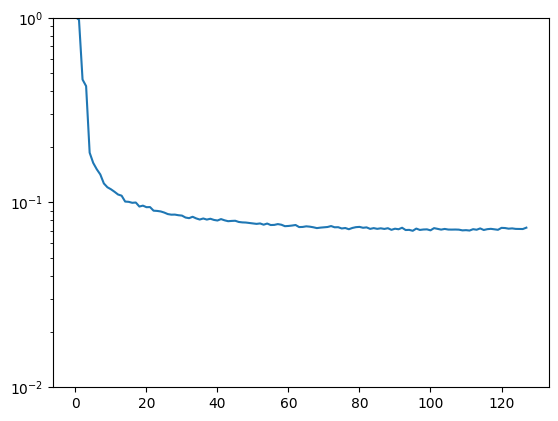

In [244]:
pd.DataFrame(mse).ewm(span=400).mean().iloc[-1].plot()
plt.yscale('log')
plt.ylim(1e-2, 1e0)

In [ ]:
da

In [54]:
dataset_train_ori['obs'].shape, dataset_train_ori['act'].shape, 

((51, 16384, 17), (51, 16384, 6))

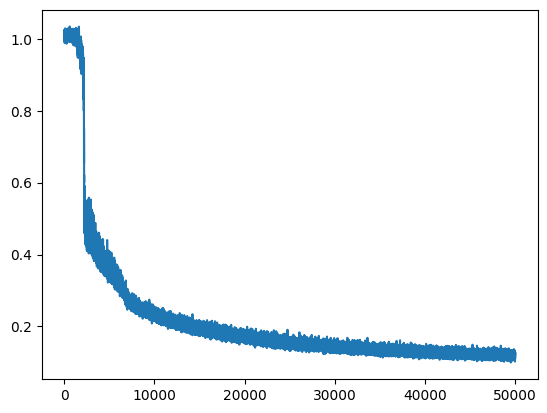

In [55]:
plt.plot(mse.mean(axis=-1))

In [55]:
rng = jax.random.PRNGKey(0)
_rng1, _rng2, _rng3 = split(rng, 3)
batch = sample_batch(_rng1, dataset_train_uni, 512, ctx_len)
batch = augment_batch(_rng2, batch, n_augs=int(1e6), dist='uniform', mat_type='orthogonal')
batch = augment_batch_permute(_rng3, batch)
act_pred = jit_vmap_agent_apply(train_state.params, batch['obs'], batch['act'])


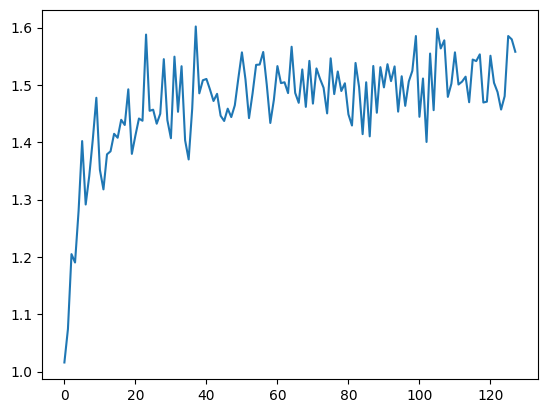

In [56]:
plt.plot(((act_pred-batch['act'])**2).mean(axis=(0, -1)))

In [24]:
a, _ = get_agent_test_loss(_rng, 512, 100, forward_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
a.shape

(51200,)

In [28]:
a

array([1.3687363 , 0.3881693 , 1.3241582 , ..., 0.837716  , 0.6593872 ,
       0.46337718], dtype=float32)

243695

In [55]:
np.random.randn

<function RandomState.randn>

In [232]:
def forward_fn_mlp(x):
    act_pred = agent_mlp.apply(params_mlp, x)
    # act_pred = act_pred+np.random.randn(*act_pred.shape)*1e-1
    return act_pred

jit_vmap_agent_apply = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))

def forward_fn_trans(x):
    bs = len(x)
    _rng = jax.random.PRNGKey(np.random.randint(low=0, high=1000000))
    batch = sample_batch(_rng, dataset_train_uni, bs*ctx_len, 1)
    batch = jax.tree_map(lambda x: x.reshape(bs, ctx_len, -1).copy(), batch)
    batch['obs'] = batch['obs'].at[:, -1].set(x)
    act_pred = jit_vmap_agent_apply(params_trans, batch['obs'], batch['act'])
    # act_pred = act_pred+np.random.randn(*act_pred.shape)*1e-1
    return act_pred[:, -1]

In [233]:
print(get_agent_test_loss(_rng, 512, 100, forward_fn_mlp)[1].mean())
print(get_agent_test_loss(_rng, 512, 100, forward_fn_trans)[1].mean())

  0%|          | 0/100 [00:00<?, ?it/s]

0.19576575


  0%|          | 0/100 [00:00<?, ?it/s]

Using causal mask
Using causal mask
0.90564835


In [68]:
def get_agent_test_loss_per_dim(rng, bs, n_iters, forward_fn):
    mse_uni, mse_ori = [], []
    for _ in tqdm(range(n_iters)):
        rng, _rng = split(rng)
        batch_ori = sample_batch(_rng, dataset_test_ori, bs, 1)
        batch_ori = jax.tree_map(lambda x: x[:, 0], batch_ori)
        batch_uni = sample_batch(_rng, dataset_test_uni, bs, 1)
        batch_uni = jax.tree_map(lambda x: x[:, 0], batch_uni)
        
        act_uni_pred = forward_fn(batch_uni['obs'])
        act_ori_pred = data_utils.inverse_transform_act(act_uni_pred, transform_params)
        mse_uni_i = jnp.square(act_uni_pred - batch_uni['act'])
        mse_ori_i = jnp.square(act_ori_pred - batch_ori['act'])
        mse_uni.append(mse_uni_i)
        mse_ori.append(mse_ori_i)
    return np.concatenate(mse_ori)

print(get_agent_test_loss_per_dim(_rng, 512, 100, forward_fn_mlp).mean(axis=0))
print(get_agent_test_loss_per_dim(_rng, 512, 100, forward_fn_trans).mean(axis=0))

  0%|          | 0/100 [00:00<?, ?it/s]

[0.4121691  0.240866   0.53826874 0.31050473 0.27653065 0.55995345]


  0%|          | 0/100 [00:00<?, ?it/s]

[0.15092736 0.14106102 0.2093865  0.12103835 0.13305767 0.2760104 ]


In [76]:
dataset_errors = dict(obs=dataset_train_uni['obs'], act=dataset_train_uni['act'], act_pred=[])
dataset_errors['obs'] = dataset_errors['obs'].reshape(-1, 512, dataset_errors['obs'].shape[-1])
dataset_errors['act'] = dataset_errors['act'].reshape(-1, 512, dataset_errors['act'].shape[-1])

for batch_obs in tqdm(dataset_errors['obs']):
    batch_act_pred = forward_fn_trans(batch_obs)
    dataset_errors['act_pred'].append(batch_act_pred)
dataset_errors['act_pred'] = np.stack(dataset_errors['act_pred'])
dataset_errors['error'] = dataset_errors['act'] - dataset_errors['act_pred']
dataset_errors = jax.tree_map(lambda x: np.array(x), dataset_errors)

  0%|          | 0/1632 [00:00<?, ?it/s]

In [77]:
print(jax.tree_map(lambda x: x.shape, dataset_errors))

{'act': (1632, 512, 16), 'act_pred': (1632, 512, 16), 'error': (1632, 512, 16), 'obs': (1632, 512, 128)}


In [78]:
x, y = dataset_errors['obs'], dataset_errors['error']
x, y = x.reshape(-1, x.shape[-1]), y.reshape(-1, y.shape[-1])
# x, y = x[:, [65]], y[:, [8]]
x.shape, y.shape

((835584, 128), (835584, 16))

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)

0.23640922421668617

In [486]:
((reg.predict(x)-y)**2).mean(axis=-1).mean()

0.10820704

In [489]:
((y)**2).mean(axis=-1).mean()

0.1462812

In [476]:
reg.score(x, y)

0.25720463535052795

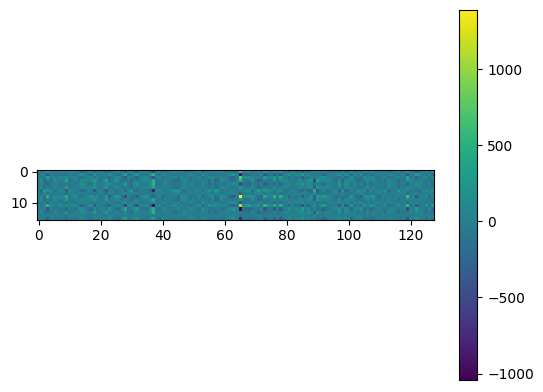

In [477]:
plt.imshow(reg.coef_)
plt.colorbar()

In [478]:
reg.coef_[8, 65]

1389.4146

In [479]:
y.shape, x.shape

((835584, 16), (835584, 128))

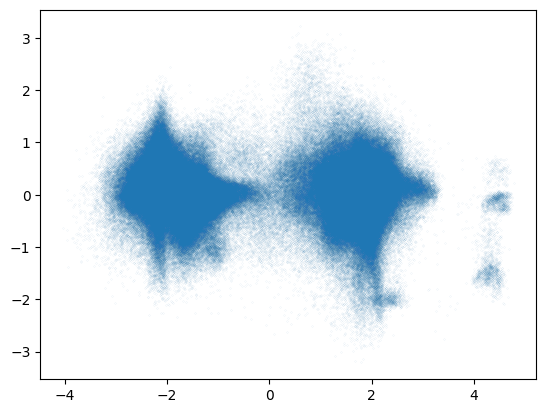

In [480]:
plt.scatter(x[:, 65], y[:, 8], s=.001)

In [176]:
rets, _, o_mlp, a_mlp = get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(forward_fn_mlp, transform_params), ret_buffer=True)
print(rets.mean())
rets, _, o_trans, a_trans = get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(forward_fn_trans, transform_params), ret_buffer=True)
print(rets.mean())

Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

2068.651


Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

310.6341


In [122]:
o_mlp.shape, a_mlp.shape

((16, 1000, 17), (16, 1000, 6))

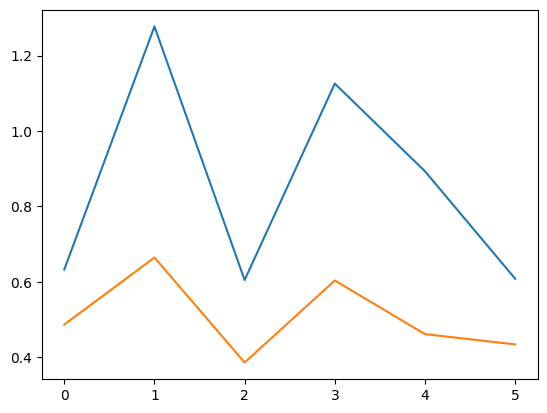

In [123]:
plt.plot(a_mlp.std(axis=(0, 1)))
plt.plot(a_trans.std(axis=(0, 1)))

In [130]:
a = transform_forward_fn(forward_fn_mlp, transform_params)(o_mlp.reshape(-1, 17))
b = transform_forward_fn(forward_fn_mlp, transform_params)(o_trans.reshape(-1, 17))
c = transform_forward_fn(forward_fn_trans, transform_params)(o_mlp.reshape(-1, 17))
d = transform_forward_fn(forward_fn_trans, transform_params)(o_trans.reshape(-1, 17))

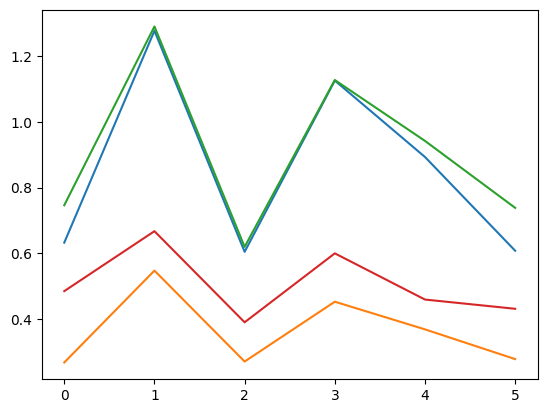

In [146]:
plt.plot(a.std(axis=0))
plt.plot(b.std(axis=0))
plt.plot(c.std(axis=0))
plt.plot(d.std(axis=0))

In [183]:
def get_agent_return_half(env_id, num_envs, n_steps, forward_fn1, forward_fn2, vid_dir=None, ret_buffer=False):
    envs = gym.vector.SyncVectorEnv(
        [make_env(f"{env_id}", i, vid_dir) for i in range(num_envs)]
    )
    forward_fn = forward_fn1
    obs, infos = envs.reset()
    o, a, r = [], [], []
    rets, lens = [], []
    for i in tqdm(range(n_steps), desc="Rollout"):
        if i==n_steps//3:
            print('swtiching')
            forward_fn = forward_fn2
        act = forward_fn(obs)
        a.append(act)
        o.append(obs)
        
        obs, rew, term, trunc, infos = envs.step(act)
        r.append(rew)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    rets.append(info["episode"]["r"])
                    lens.append(info["episode"]["l"])
    if ret_buffer:
        return np.array(rets), np.array(lens), np.stack(o, axis=1), np.stack(a, axis=1), np.stack(r, axis=1)
    else:
        return np.array(rets), np.array(lens)


rets, _, _, _, r = get_agent_return_half(env_id_gym, 16, 1000,
                                      transform_forward_fn(forward_fn_mlp, transform_params),
                                      transform_forward_fn(forward_fn_trans, transform_params), ret_buffer=True)
print(rets.mean())




Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

swtiching
945.4905


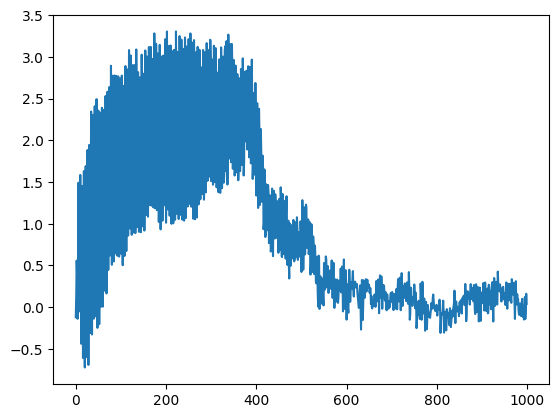

In [184]:
plt.plot(r.mean(axis=0))

In [234]:
print(get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(forward_fn_mlp, transform_params),
                       vid_dir="./videos/mlp_hopper/")[0].mean())
print(get_agent_return(env_id_gym, 16, 1000, transform_forward_fn(forward_fn_trans, transform_params),
                       vid_dir="./videos/trans_hopper/")[0].mean())

Exception ignored in: <function GLContext.__del__ at 0x7f8a2c3581f0>
Traceback (most recent call last):
  File "/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/mujoco/glfw/__init__.py", line 41, in __del__
    self.free()
  File "/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/mujoco/glfw/__init__.py", line 34, in free
    if self._context:
AttributeError: 'GLContext' object has no attribute '_context'


Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-0.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-0.mp4




t: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 164.89it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-0.mp4
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-1.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-1.mp4




t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 93/109 [00:00<00:00, 206.85it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-1.mp4
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-8.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-8.mp4




t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 92/106 [00:00<00:00, 230.36it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/mlp_hopper/rl-video-episode-8.mp4


Exception ignored in: <function GLContext.__del__ at 0x7f8a2c3581f0>
Traceback (most recent call last):
  File "/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/mujoco/glfw/__init__.py", line 41, in __del__
    self.free()
  File "/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/mujoco/glfw/__init__.py", line 34, in free
    if self._context:
AttributeError: 'GLContext' object has no attribute '_context'


148.17787


Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

Using causal mask
Using causal mask
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-0.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-0.mp4




t:   0%|                                                                                                                                                                                                            | 0/15 [00:00<?, ?it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-0.mp4
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-1.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-1.mp4




t:   0%|                                                                                                                                                                                                            | 0/17 [00:00<?, ?it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-1.mp4
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-8.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-8.mp4




t:   0%|                                                                                                                                                                                                            | 0/15 [00:00<?, ?it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-8.mp4
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-27.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-27.mp4




t:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 48/61 [00:00<00:00, 233.47it/s, now=None]
                                                                                                                                                                                                                                                     

Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/trans_hopper/rl-video-episode-27.mp4
55.475727


In [283]:
rng = jax.random.PRNGKey(0)
_rng1, _rng2, _rng3 = split(rng, 3)
batch = sample_batch(_rng1, dataset_train_uni, 512, 1)
batch = jax.tree_map(lambda x: x[:, 0], batch)

act_pred_mlp = forward_fn_mlp(batch['obs'])
act_pred_trans = forward_fn_trans(batch['obs'])



In [284]:
print(((act_pred_mlp-batch['act'])**2).mean(axis=-1).mean())
print(((act_pred_trans-batch['act'])**2).mean(axis=-1).mean())
print(((act_pred_mlp-act_pred_trans)**2).mean(axis=-1).mean())
print(((act_pred_mlp)**2).mean(axis=-1).mean())
print(((act_pred_trans)**2).mean(axis=-1).mean())
print(((batch['act'])**2).mean(axis=-1).mean())

0.29306695
0.14653054
0.17419751
0.5275346
0.87210363
1.0179875


In [285]:
def get_agent_return_obs(env_id, num_envs, n_steps, forward_fn, vid_dir=None):
    envs = gym.vector.SyncVectorEnv(
        [make_env(f"{env_id}", i, vid_dir) for i in range(num_envs)]
    )
    o = []
    obs, infos = envs.reset()
    rets, lens = [], []
    for _ in tqdm(range(n_steps), desc="Rollout"):
        o.append(obs)
        act = forward_fn(obs)
        obs, rew, term, trunc, infos = envs.step(act)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    rets.append(info["episode"]["r"])
                    lens.append(info["episode"]["l"])
    return np.array(rets), np.array(lens), np.stack(o, axis=1)

In [286]:
rets, _, o_mlp = get_agent_return_obs(env_id_gym, 16, 200, transform_forward_fn(forward_fn_mlp, transform_params))
rets, _, o_trans = get_agent_return_obs(env_id_gym, 16, 200, transform_forward_fn(forward_fn_trans, transform_params))

Rollout:   0%|          | 0/200 [00:00<?, ?it/s]

Rollout:   0%|          | 0/200 [00:00<?, ?it/s]

In [287]:
o_mlp.shape

(16, 200, 17)

In [288]:
o_trans.shape

(16, 200, 17)

In [289]:
a = transform_forward_fn(forward_fn_mlp, transform_params)(o_mlp[:, -2, :])
b = transform_forward_fn(forward_fn_mlp, transform_params)(o_mlp[:, -1, :])

In [290]:
(b-a)

Array([[-1.2020946 , -0.11497271,  1.0478193 , -0.72019184,  0.95913494,
         1.3211136 ],
       [ 0.6855935 , -2.6088872 ,  0.68307686,  2.3170393 , -1.7160206 ,
        -0.27862075],
       [-1.1827128 , -0.07384729,  0.98885727, -0.73942065,  0.9554085 ,
         1.2881879 ],
       [ 0.62987846, -2.7217398 ,  0.7417551 ,  2.362443  , -1.7437328 ,
        -0.20414001],
       [ 1.1478577 ,  0.05212486, -0.9698221 ,  0.66180855, -0.8803539 ,
        -1.186016  ],
       [-0.7660601 , -1.1124667 ,  1.0803264 ,  0.2739396 ,  0.11465436,
         1.0343356 ],
       [-1.149256  , -0.1926806 ,  1.0111406 , -0.62694335,  0.870914  ,
         1.2795062 ],
       [-1.1749234 , -0.15945911,  1.0452751 , -0.6649817 ,  0.94653213,
         1.33674   ],
       [ 0.69885963, -2.6244998 ,  0.65054786,  2.345901  , -1.7796854 ,
        -0.32792574],
       [-0.8274874 , -0.9304908 ,  1.112943  ,  0.09271932,  0.26482934,
         1.0365069 ],
       [ 0.63980484, -2.671651  ,  0.73803496,  2.

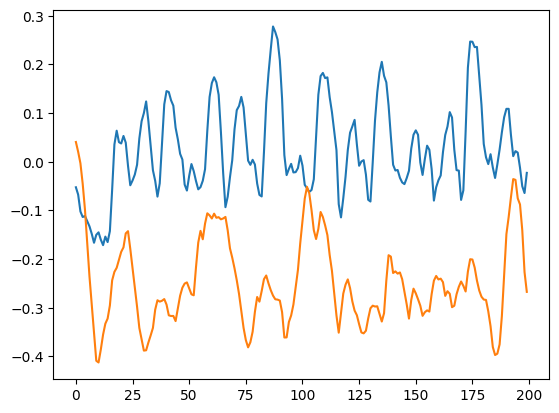

In [292]:
plt.plot(o_mlp[0, :, 0])
plt.plot(o_trans[0, :, 0])


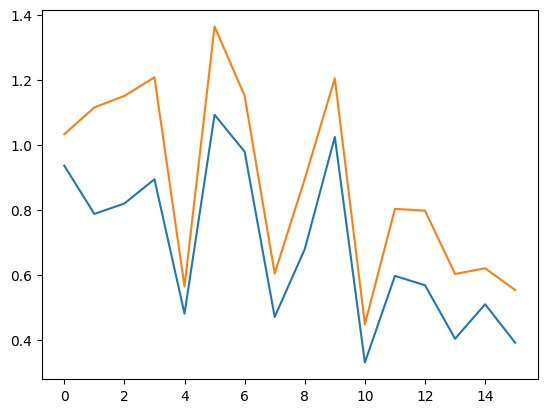

In [222]:
plt.plot(act_pred_mlp.std(axis=0))
plt.plot(act_pred_trans.std(axis=0))
# plt.ylim(0, 1)

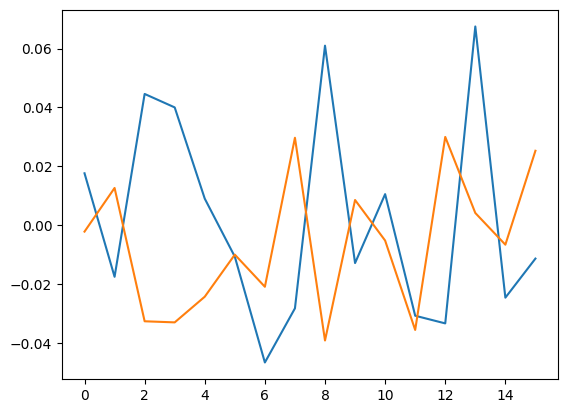

In [221]:
plt.plot((act_pred_mlp-batch['act']).mean(axis=0))
plt.plot((act_pred_trans-batch['act']).mean(axis=0))

In [22]:
def get_agent_test_loss(rng, bs, n_iters, forward_fn):
    mse_uni, mse_ori = [], []
    a, b = [], []
    for _ in tqdm(range(n_iters)):
        rng, _rng = split(rng)
        batch_ori = sample_batch(_rng, dataset_test_ori, bs, 1)
        batch_ori = jax.tree_map(lambda x: x[:, 0], batch_ori)
        batch_uni = sample_batch(_rng, dataset_test_uni, bs, 1)
        batch_uni = jax.tree_map(lambda x: x[:, 0], batch_uni)
        
        act_uni_pred = forward_fn(batch_uni['obs'])
        a.append(act_uni_pred)
        act_ori_pred = data_utils.inverse_transform_act(act_uni_pred, transform_params)
        b.append(act_ori_pred)
        mse_uni_i = jnp.mean(jnp.square(act_uni_pred - batch_uni['act']))
        mse_ori_i = jnp.mean(jnp.square(act_ori_pred - batch_ori['act']))
        mse_uni.append(mse_uni_i)
        mse_ori.append(mse_ori_i)
    return jnp.stack(mse_uni).mean(), jnp.stack(mse_ori).mean(), np.array(a), np.array(b)

_, _, a, b = get_agent_test_loss(_rng, 512, 100, forward_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
b.shape

(100, 512, 6)

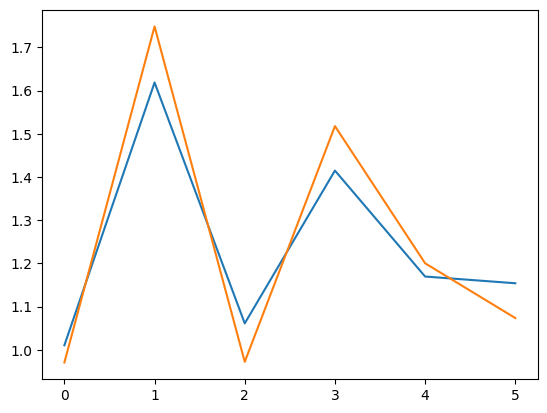

In [38]:
plt.plot(dataset_train_ori['act'].std(axis=(0, 1)))
plt.plot((b*1.2).std(axis=(0, 1)))

Array([1.010343 , 1.6187373, 1.0610229, 1.4147857, 1.1694658, 1.1538998],      dtype=float32)

In [39]:
obs_traj, act_traj = [], []

def get_agent_return(env_id, num_envs, n_steps, forward_fn, vid_name=None):
    capture_video = vid_name is not None
    envs = gym.vector.SyncVectorEnv(
        [make_env(f"{env_id}-v4", i, capture_video, vid_name, 0.99) for i in range(num_envs)]
    )
    obs, infos = envs.reset()
    stats = dict(ret=[], len=[])
    for _ in tqdm(range(n_steps), desc="Rollout"):
        obs_agent = data_utils.transform_obs(obs, transform_params)
        act_agent = forward_fn(obs_agent)
        act = data_utils.inverse_transform_act(act_agent, transform_params)
        obs_traj.append(obs)
        act_traj.append(act)
        obs, rew, term, trunc, infos = envs.step(act)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    stats["ret"].append(info["episode"]["r"])
                    stats["len"].append(info["episode"]["l"])
    return dict(ret=np.array(stats["ret"]), len=np.array(stats["len"]))


def forward_fn(x):
    _rng = jax.random.PRNGKey(0)
    batch = sample_batch(_rng, dataset_train_uni, len(x), ctx_len)
    batch = jax.tree_map(lambda x: x.copy(), batch)
    batch['obs'] = batch['obs'].at[:, -1].set(x)
    act_pred = jit_vmap_agent_apply(train_state.params, batch['obs'], batch['act'])
    return act_pred[:, -1]*1.2

a = get_agent_return(env_id, 16, 1000, forward_fn, vid_name="test")

/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Exception ignored in: <function GLContext.__del__ at 0x7f69563fcee0>
Traceback (most recent call last):
  File "/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/mujoco/glfw/__init__.py", line 41, in __del__
    self.free()
  File "/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/lib/python3.10/site-packages/mujoco/glfw/__init__.py", line 34, in free
    if self._context:
AttributeError: 'GLContext' object has no attribute '_context'


Rollout:   0%|          | 0/1000 [00:00<?, ?it/s]

Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test/rl-video-episode-0.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test/rl-video-episode-0.mp4
Moviepy - Building video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test/rl-video-episode-1.mp4.
Moviepy - Writing video /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /data/vision/phillipi/akumar01/synthetic-mdps/src/videos/test/rl-video-episode-1.mp4


In [40]:
a

{'ret': array([[ -168.65742 ],
        [-1065.5077  ],
        [ -291.45038 ],
        [ -359.03244 ],
        [ -128.70569 ],
        [ -234.02638 ],
        [ -277.12744 ],
        [ -154.81503 ],
        [ -156.60506 ],
        [  344.04956 ],
        [  694.9767  ],
        [ -253.03209 ],
        [ -246.39662 ],
        [  -89.80522 ],
        [   95.058914],
        [  -40.910603]], dtype=float32),
 'len': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]], dtype=int32)}

In [41]:
obs_traj = np.stack(obs_traj, axis=1)
act_traj = np.stack(act_traj, axis=1)

In [42]:
obs_traj_gt = dataset_train_ori['obs'][:16, :1000, :]
act_traj_gt = dataset_train_ori['act'][:16, :1000, :]

In [43]:
act_traj_gt.mean(axis=(0, 1)), act_traj_gt.std(axis=(0, 1))

(Array([-0.16212709, -0.00682688,  0.25871134,  0.52973366,  0.23586006,
         0.43914592], dtype=float32),
 Array([1.0414071, 1.5978317, 1.0640277, 1.4222304, 1.1395996, 1.1671901],      dtype=float32))

In [44]:
act_traj.mean(axis=(0, 1)), act_traj.std(axis=(0, 1))

(array([ 0.54006606,  0.2370736 , -0.23254322,  0.90058124,  0.14579651,
         0.1721373 ], dtype=float32),
 array([0.38725248, 0.8874443 , 0.39808917, 0.5771986 , 0.686238  ,
        0.5513975 ], dtype=float32))

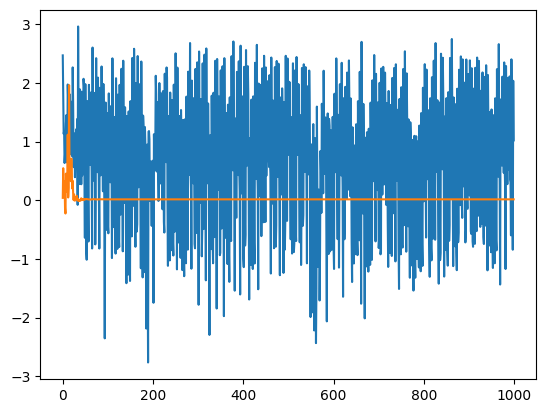

In [45]:
plt.plot(act_traj_gt[0, :, 5])
plt.plot(act_traj[0, :, 5])

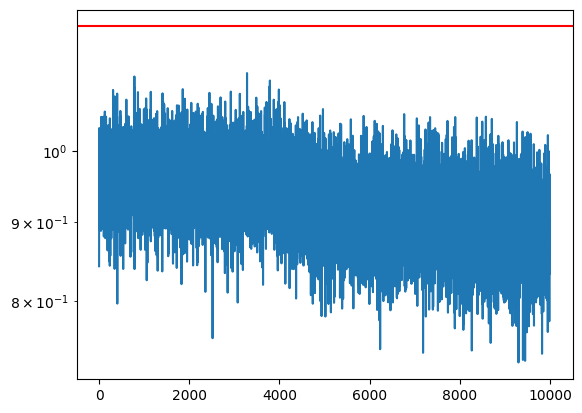

In [59]:
plt.plot(losses)
plt.axhline(data_trans[-1, 1], c='r')
plt.yscale('log')

In [123]:
data_trans

array([[-65.56523   ,   1.0092175 ,   1.577535  ],
       [-79.664375  ,   0.15325008,   0.209239  ]], dtype=float32)

In [301]:
data_trans

array([[-1.1675856e+01,  9.7675544e-01,  7.7022789e-03],
       [-3.8139834e+00,  3.0381714e-03,  2.3699989e-05]], dtype=float32)

In [287]:
batch = sample_batch(_rng, dataset_train_uni, bs, ctx_len)
a, b = jax.vmap(partial(agent.apply, train_state.params, mutable='intermediates'))(batch['obs'], batch['act'])

Using causal mask
Using causal mask


In [288]:
a.shape

(32, 128, 16)

In [289]:
jax.tree_map(lambda x: x.shape, b)

{'intermediates': {'blocks_0': {'mha': {'attention_weights': ((32,
      4,
      128,
      128),)}},
  'blocks_1': {'mha': {'attention_weights': ((32, 4, 128, 128),)}}}}

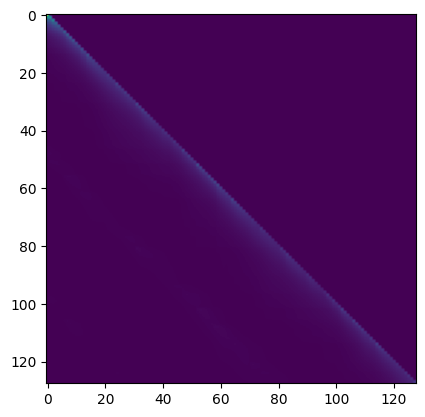

In [290]:
plt.imshow(b['intermediates']['blocks_0']['mha']['attention_weights'][0].mean(axis=(0, 1)))

In [248]:
a = dataset_train_uni['act']
print(a.shape)
print(np.diff(a, axis=1).mean(axis=-1).mean())

(51, 16384, 16)
-8.581538e-06


In [272]:
a.shape

(51, 16384, 16)

In [273]:
b = ((a[:, 1:] - a[:, :-1])**2).mean(axis=-1)

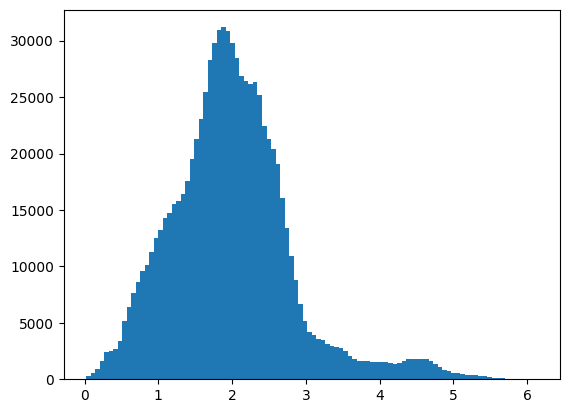

In [261]:
plt.hist(np.array(b.flatten()), bins=100);

(0.0, 100.0)

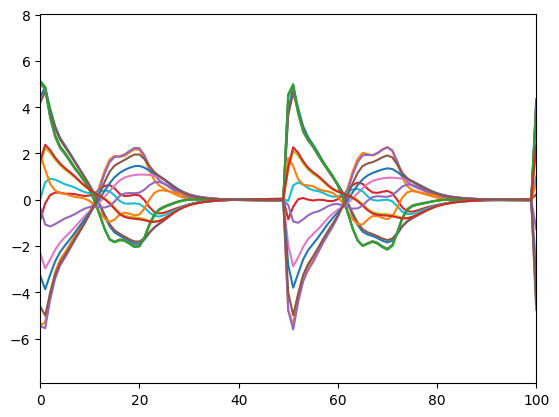

In [273]:
plt.plot(a[0, :, :])
plt.xlim(0, 100)

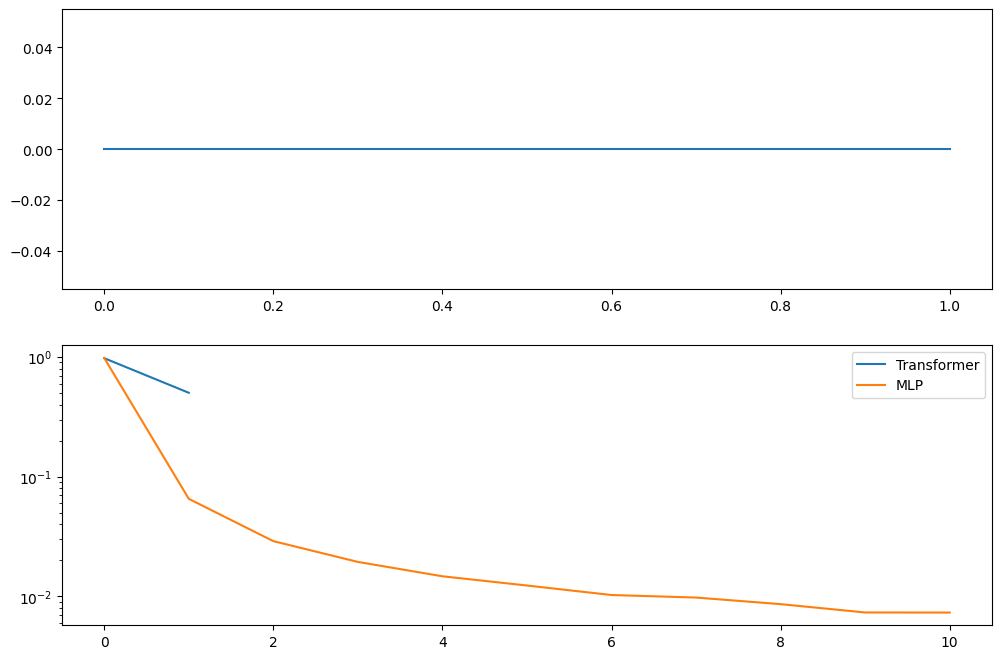

In [158]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(data_trans[:, 0], label="Rollout Return")
plt.subplot(212)
plt.plot(data_trans[:, 1], label="Transformer")
plt.plot(data_mlp[:, 1], label="MLP")
plt.yscale('log')
plt.legend()
plt.show()


(51, 16384, 128)

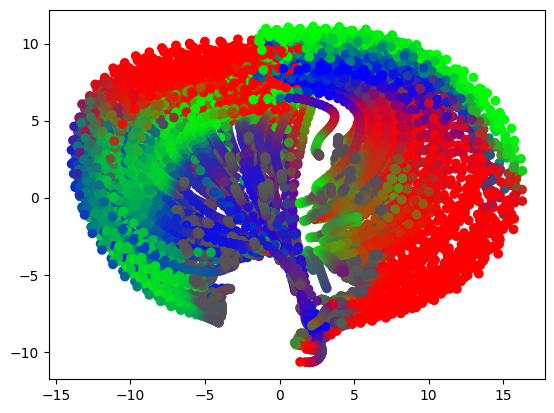

In [71]:
from sklearn.decomposition import PCA

def viz_dataset(dataset):
    obs, act = dataset['obs'], dataset['act']
    obs, act = obs[:1], act[:1]
    obs, act = obs.reshape(-1, obs.shape[-1]), act.reshape(-1, act.shape[-1])
    obs2d = PCA(n_components=2).fit_transform(obs)
    act3d = PCA(n_components=3).fit_transform(act)
    # use act3d as color
    act3d = np.array(jax.nn.softmax(act3d, axis=-1))
    plt.scatter(obs2d[:, 0], obs2d[:, 1], c=act3d)

viz_dataset(dataset_train_uni)

In [ ]:
def forward_fn_mlp(x):
    act_pred = agent_mlp.apply(params_mlp, x)
    return act_pred

jit_vmap_agent_apply = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))

def forward_fn_trans(x):
    bs = len(x)
    _rng = jax.random.PRNGKey(np.random.randint(low=0, high=1000000))
    batch = sample_batch(_rng, dataset_train_uni, bs*ctx_len, 1)
    batch = jax.tree_map(lambda x: x.reshape(bs, ctx_len, -1).copy(), batch)
    batch['obs'] = batch['obs'].at[:, -1].set(x)
    act_pred = jit_vmap_agent_apply(params_trans, batch['obs'], batch['act'])
    # act_pred = act_pred+np.random.randn(*act_pred.shape)*1e-1
    return act_pred[:, -1]

In [188]:
jit_vmap_agent_apply = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0)))

In [194]:
def temp(env_id, num_envs, n_steps, vid_dir=None):
    envs = gym.vector.SyncVectorEnv(
        [make_env(f"{env_id}", i, vid_dir) for i in range(num_envs)]
    )
    obs, infos = envs.reset()

    p_agent_obs, p_agent_act = [], []
    
    rets, lens = [], []
    for i in tqdm(range(n_steps), desc="Rollout"):
        obs_agent = data_utils.transform_obs(obs, transform_params)

        p_agent_obs.append(obs_agent)
        p_agent_act.append(jnp.zeros((num_envs, d_act_uni)))
        p_agent_obs, p_agent_act = p_agent_obs[-ctx_len:], p_agent_act[-ctx_len:]
        
        if len(p_agent_obs)<ctx_len:
            act_agent = jax.vmap(agent_mlp.apply, in_axes=(None, 0))(params_mlp, obs_agent)
        else:
            p_agent_obs_v = jnp.stack(p_agent_obs, axis=1)
            p_agent_act_v = jnp.stack(p_agent_act, axis=1)

            a = jit_vmap_agent_apply(params_trans, p_agent_obs_v, p_agent_act_v)
            # a = a+np.random.randn(*a.shape)*1e0
            act_agent = a[:, -1, :]

        p_agent_act[-1] = act_agent

        act = data_utils.inverse_transform_act(act_agent, transform_params)
        obs, rew, term, trunc, infos = envs.step(act)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    rets.append(info["episode"]["r"])
                    lens.append(info["episode"]["l"])
    return np.array(rets), np.array(lens)


rets, lens = temp(env_id_gym, 16, 2000)
print(rets.mean())

Rollout:   0%|          | 0/2000 [00:00<?, ?it/s]

545.2518


In [196]:
rets.shape

(32, 1)

In [197]:
rets[:16].mean()

833.02466

In [198]:
rets[16:].mean()

257.4789

In [190]:
batch = sample_batch(_rng, dataset_train_uni, 512, ctx_len)

a = jax.vmap(agent.apply, in_axes=(None, 0, 0))(params_trans, batch['obs'], batch['act'])

Using causal mask
Using causal mask


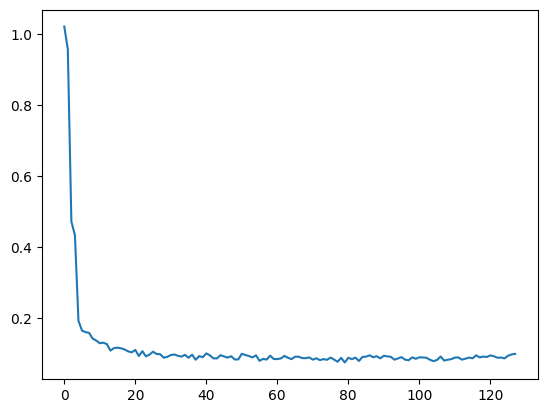

In [191]:
plt.plot(((a-batch['act'])**2).mean(axis=-1).mean(axis=0))

In [6]:
from util import load_pkl

In [6]:
data_oracle = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/HalfCheetah_oracle", "metrics_test")
data_oracle_aug = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/HalfCheetah_oracle_aug", "metrics_test")
df_o = pd.DataFrame(data_oracle['mse_act'])
df_oa = pd.DataFrame(data_oracle_aug['mse_act'])

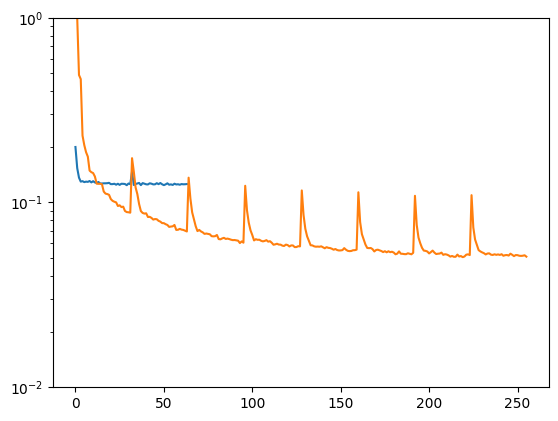

In [353]:
df_o.ewm(span=100).mean().iloc[-1].plot()
df_oa.ewm(span=100).mean().iloc[-1].plot()
plt.ylim(1e-2, 1e0)
plt.yscale('log')

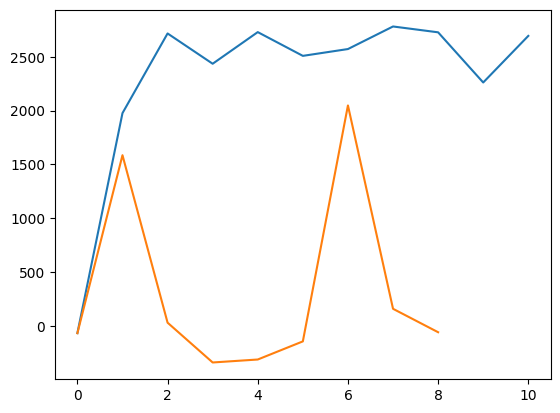

In [354]:
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/HalfCheetah_oracle", "rollout_data")
plt.plot(np.array(a)[:, :, 0].mean(axis=-1))
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/HalfCheetah_oracle_aug", "rollout_data")
plt.plot(np.array(a)[:, :, 0].mean(axis=-1))

In [18]:
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/HalfCheetah_oracle_aug_16", "rollout_data")
print(a[-1].mean())
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/Ant_oracle_aug_16", "rollout_data")
print(a[-1].mean())
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/Swimmer_oracle_aug_16", "rollout_data")
print(a[-1].mean())

3097.558349609375
2754.531120300293
126.33930540084839


0.15598533
0.092864744

0.19067161
0.13922484


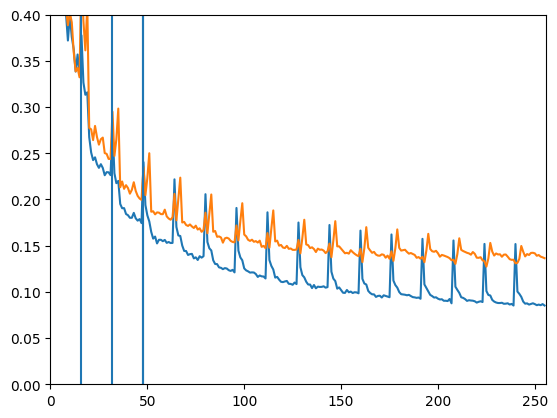

In [104]:
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc/HalfCheetah_gato_aug_16_rollout/", "metrics_before")
a = a['mse_act']
plt.plot(a.mean(axis=0))
print(a.mean())
print(a.mean(axis=0).reshape(16, 16)[-1].mean())
print()
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc/HalfCheetah_gato_aug_diff_rollout/", "metrics_before")
a = a['mse_act']
plt.plot(a.mean(axis=0))
print(a.mean())
print(a.mean(axis=0).reshape(16, 16)[-1].mean())


plt.ylim(0, 0.4)

plt.xlim(0, 256)
plt.axvline(16)
plt.axvline(32)
plt.axvline(48)
plt.axvline(48)


In [108]:
def sample_batch_segments_from_dataset(rng, dataset, batch_size, n_segs, seg_len):
    rng, _rng1, _rng2 = split(rng, 3)
    n_e, n_t, *_ = dataset['obs'].shape
    if False:
        i_e = jax.random.randint(_rng1, (batch_size, n_segs, 1), minval=0, maxval=n_e)
    else:
        i_e = jax.random.randint(_rng1, (batch_size, 1, 1), minval=0, maxval=n_e)
    i_t = jax.random.randint(_rng2, (batch_size, n_segs, 1), minval=0, maxval=n_t - seg_len)
    i_t = i_t + jnp.arange(seg_len)
    batch = jax.tree_map(lambda x: x[i_e, i_t, ...], dataset)
    return batch

In [109]:
a, b = jnp.arange(64), jnp.arange(16384)
a, b = jnp.meshgrid(a, b, indexing='ij')
dataset = dict(obs=jnp.stack([a, b], axis=-1))

In [110]:
rng = jax.random.PRNGKey(0)
batch = sample_batch_segments_from_dataset(rng, dataset, 32, 3, 16)

In [113]:
batch['obs'][0]

Array([[[    1, 16147],
        [    1, 16148],
        [    1, 16149],
        [    1, 16150],
        [    1, 16151],
        [    1, 16152],
        [    1, 16153],
        [    1, 16154],
        [    1, 16155],
        [    1, 16156],
        [    1, 16157],
        [    1, 16158],
        [    1, 16159],
        [    1, 16160],
        [    1, 16161],
        [    1, 16162]],

       [[    1,  2255],
        [    1,  2256],
        [    1,  2257],
        [    1,  2258],
        [    1,  2259],
        [    1,  2260],
        [    1,  2261],
        [    1,  2262],
        [    1,  2263],
        [    1,  2264],
        [    1,  2265],
        [    1,  2266],
        [    1,  2267],
        [    1,  2268],
        [    1,  2269],
        [    1,  2270]],

       [[    1, 11631],
        [    1, 11632],
        [    1, 11633],
        [    1, 11634],
        [    1, 11635],
        [    1, 11636],
        [    1, 11637],
        [    1, 11638],
        [    1, 11639],
        [   

<Axes: >

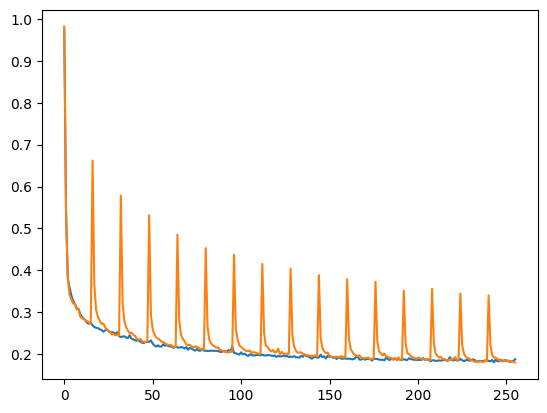

In [102]:
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/large/HalfCheetah_gato_aug_16/", "metrics_train")
a = pd.DataFrame(a['mse_act'])
a.ewm(span=1000).mean().iloc[-1].plot()
a = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc/HalfCheetah_gato_aug/", "metrics_train")
a = pd.DataFrame(a['mse_act'])
a.ewm(span=1000).mean().iloc[-1].plot()

Text(150, 0.7, 'ft: 5032.660+-26.220')

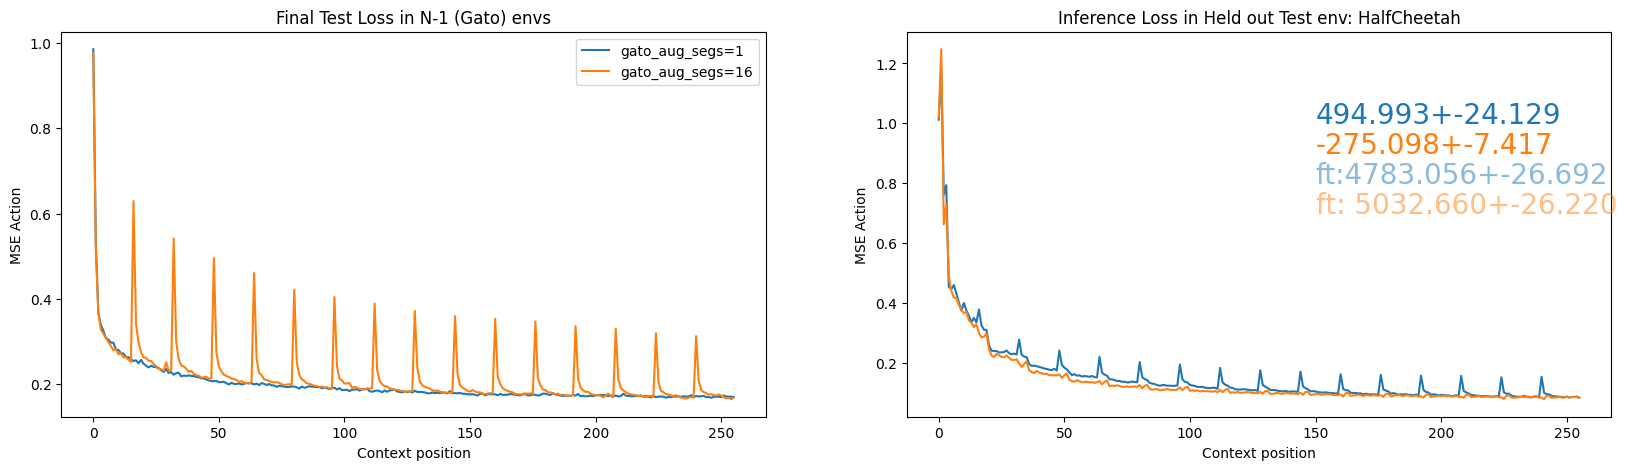

In [129]:
env_id = "HalfCheetah"

plt.figure(figsize=(20, 5))
plt.subplot(121)
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_1/", "metrics_test")
a = pd.DataFrame(a['mse_act'])
a.ewm(span=500).mean().iloc[-1].plot(label='gato_aug_segs=1')
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_16/", "metrics_test")
a = pd.DataFrame(a['mse_act'])
a.ewm(span=500).mean().iloc[-1].plot(label='gato_aug_segs=16')
plt.title("Final Test Loss in N-1 (Gato) envs")
plt.ylabel("MSE Action")
plt.xlabel("Context position")
plt.legend()

plt.subplot(122)
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_1_rollout_16/", "metrics_before")
a = pd.DataFrame(a['mse_act'])
a.mean(axis=0).plot(label='gato_aug_segs=1')
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_16_rollout_16/", "metrics_before")
a = pd.DataFrame(a['mse_act'])
a.mean(axis=0).plot(label='gato_aug_segs=16')
plt.title(f"Inference Loss in Held out Test env: {env_id}")
plt.ylabel("MSE Action")
plt.xlabel("Context position")

a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_1_rollout_16/", "rollout_data")
plt.text(150, 1., f"{a[0].mean():.03f}+-{a[0].std()/32:.03f}", fontsize=20, c='tab:blue')
plt.text(150, .8, f"ft:{a[1].mean():.03f}+-{a[1].std()/32:.03f}", fontsize=20, c='tab:blue', alpha=0.5)
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_16_rollout_16/", "rollout_data")
plt.text(150, .9, f"{a[0].mean():.03f}+-{a[0].std()/32:.03f}", fontsize=20, c='tab:orange')
plt.text(150, .7, f"ft: {a[1].mean():.03f}+-{a[1].std()/32:.03f}", fontsize=20, c='tab:orange', alpha=0.5)


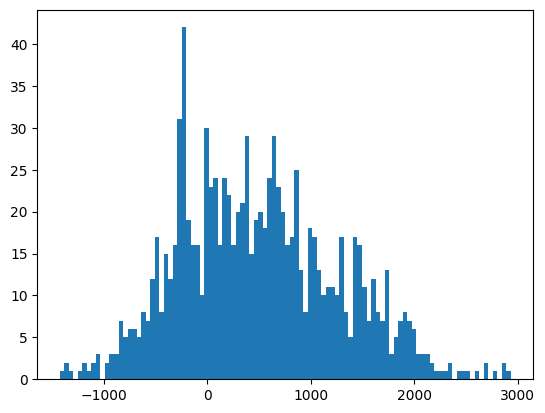

In [130]:
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_1_rollout_16/", "rollout_data")
plt.hist(a[0].squeeze(), bins=100);

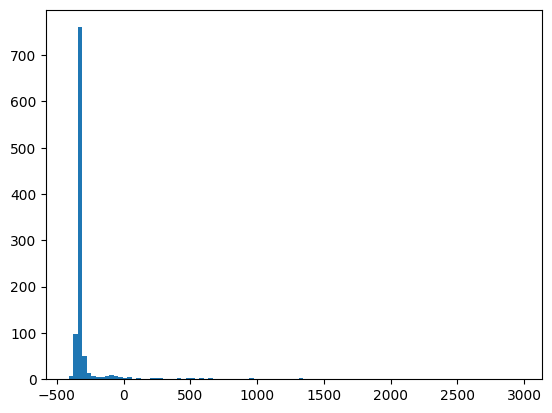

In [131]:
a = load_pkl(f"/data/vision/phillipi/akumar01/synthetic-mdps-data/iclbc_final2/{env_id}_gato_aug_16_rollout_16/", "rollout_data")
plt.hist(a[0].squeeze(), bins=100);